In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [4]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [5]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

In [6]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [7]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [8]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [9]:
# check the data
df.head(20)

Unnamed: 0   CBSA          UPT          VRM  \
ID                        Year                                                
Akron, OH Metro Area-Bus  2002           0  10420  5226385.660  4026372.388   
                          2003           1  10420  5395901.888  3976568.624   
                          2004           2  10420  5907162.281  4315392.555   
                          2005           3  10420  6013680.881  4053011.065   
                          2006           4  10420  6070797.419  3994786.013   
                          2007           5  10420  5868746.078  4571428.064   
                          2008           6  10420  6140428.988  3873343.976   
                          2009           7  10420  5560854.064  3431434.413   
                          2010           8  10420  5616567.806  3471447.493   
                          2011           9  10420  5858952.685  3918014.086   
                          2012          10  10420  5996224.469  3862989.104   
                          2013          11  10420  5976078.010  4166725.990   
                          2014          12  10420  5980821.699  4330272.662   
                          2015          13  10420  5854274.894  4561689.737   
                          2016          14  10420  5500944.573  4395640.780   
                          2017          15  10420  5461311.530  4440851.607   
                          2018          16  10420  5427485.555  4437372.601   
Albany, GA Metro Area-Bus 2002          17  10500   628324.000   532194.000   
                          2003          18  10500   670941.000   536264.000   
                          2004          19  10500   666328.000   537714.000   

                                    UPT_ADJ      VRM_ADJ      VRH_ADJ  \
ID                        Year                                          
Akron, OH Metro Area-Bus  2002  5226385.660  4026372.388  270506.6928   
                          2003  5395901.888  3976568.624  270398.3688   
                          2004  5907162.281  4315392.555  597239.8605   
                          2005  6013680.881  4053011.065  281367.9792   
                          2006  6070797.419  3994786.013  281536.7841   
                          2007  5868746.078  4571428.064  285205.3569   
                          2008  6140428.988  3873343.976  260212.3020   
                          2009  5560854.064  3431434.413  276561.1017   
                          2010  5616567.806  3471447.493  299926.5885   
                          2011  5858952.685  3918014.086  305079.2001   
                          2012  5996224.469  3862989.104  305728.2414   
                          2013  5976078.010  4166725.990  333046.6515   
                          2014  5980821.699  4330272.662  338313.0033   
                          2015  5854274.894  4561689.737  343816.7652   
                          2016  5500944.573  4395640.780  342506.0448   
                          2017  5461311.530  4440851.607  345419.0577   
                          2018  5427485.555  4437372.601  343533.3174   
Albany, GA Metro Area-Bus 2002   628324.000   532194.000   32300.0000   
                          2003   670941.000   536264.000   32108.0000   
                          2004   666328.000   537714.000   32093.0000   

                                FARE_TOTAL  FARE_per_UPT  AREALANDPT  \
ID                        Year                                         
Akron, OH Metro Area-Bus  2002    660887.0      0.126452   744634347   
                          2003   2568502.0      0.476010   744634347   
                          2004   2524882.0      0.427427   744634347   
                          2005   3022880.0      0.502667   744634347   
                          2006   3163036.0      0.521025   744634347   
                          2007   3445013.0      0.587010   744634347   
                          2008   3602006.0      0.586605   744634347   
                          2009   33874

In [10]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [11]:
#group by to get the original values
summary_data_gt = df.groupby(by=['CLUSTER_GT', 'RAIL_FLAG', 'Year']).agg('sum')
summary_data_apta = df.groupby(by=['CLUSTER_APTA', 'RAIL_FLAG', 'Year']).agg('sum')
summary_data_apta_hml = df.groupby(by=['CLUSTER_APTA_HML', 'RAIL_FLAG', 'Year']).agg('sum')

In [12]:
summary_data_gt.to_csv('original_GT_CLUSTERS.csv')
summary_data_apta.to_csv('original_APTA_CLUSTERS.csv')
summary_data_apta_hml.to_csv('original_APTA_HML_CLUSTERS.csv')

## Calculate all differences and log differences

In [13]:
# start by dropping fields already present
drop_fields = []

for col in df.columns: 
    if '_diff' in col: 
        drop_fields.append(col)
    if '_log' in col: 
        drop_fields.append(col)
    if '_scale' in col: 
        drop_fields.append(col)
        
df = df.drop(columns=drop_fields)

In [14]:
# do not transform categorical fields
category_fields = ['BUS_FLAG', 'RAIL_FLAG', 'CLUSTER_GT', 'CLUSTER_APTA', 'CLUSTER_APTA_HML']

In [15]:
# take the log of all fields
for col in df.columns: 
    if not col in category_fields: 
        df[col+'_log'] = np.log(1+df[col])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log


In [16]:
# calculate the first difference and drop the boundary cases where the CBSA number changes
df = df.sort_index()
for col in df.columns: 
    if not col in category_fields: 
        df[col] = df[col].diff()    
    
df = df[df['CBSA']==0]

In [17]:
df.head(20)

CBSA         UPT         VRM     UPT_ADJ  \
ID                        Year                                             
Akron, OH Metro Area-Bus  2003   0.0  169516.228  -49803.764  169516.228   
                          2004   0.0  511260.393  338823.931  511260.393   
                          2005   0.0  106518.600 -262381.490  106518.600   
                          2006   0.0   57116.538  -58225.052   57116.538   
                          2007   0.0 -202051.341  576642.051 -202051.341   
                          2008   0.0  271682.910 -698084.088  271682.910   
                          2009   0.0 -579574.924 -441909.563 -579574.924   
                          2010   0.0   55713.742   40013.080   55713.742   
                          2011   0.0  242384.879  446566.593  242384.879   
                          2012   0.0  137271.784  -55024.982  137271.784   
                          2013   0.0  -20146.459  303736.886  -20146.459   
                          2014   0.0    4743.689  163546.672    4743.689   
                          2015   0.0 -126546.805  231417.075 -126546.805   
                          2016   0.0 -353330.321 -166048.957 -353330.321   
                          2017   0.0  -39633.043   45210.827  -39633.043   
                          2018   0.0  -33825.975   -3479.006  -33825.975   
Albany, GA Metro Area-Bus 2003   0.0   42617.000    4070.000   42617.000   
                          2004   0.0   -4613.000    1450.000   -4613.000   
                          2005   0.0  -12452.000   -2031.000  -12452.000   
                          2006   0.0  108934.000   -1464.000  108934.000   

                                   VRM_ADJ      VRH_ADJ  FARE_TOTAL  \
ID                        Year                                        
Akron, OH Metro Area-Bus  2003  -49803.764    -108.3240   1907615.0   
                          2004  338823.931  326841.4917    -43620.0   
                          2005 -262381.490 -315871.8813    497998.0   
                          2006  -58225.052     168.8049    140156.0   
                          2007  576642.051    3668.5728    281977.0   
                          2008 -698084.088  -24993.0549    156993.0   
                          2009 -441909.563   16348.7997   -214516.0   
                          2010   40013.080   23365.4868    210338.0   
                          2011  446566.593    5152.6116    204186.0   
                          2012  -55024.982     649.0413   2660976.0   
                          2013  303736.886   27318.4101    241943.0   
                          2014  163546.672    5266.3518    190022.0   
                          2015  231417.075    5503.7619   -614367.0   
                          2016 -166048.957   -1310.7204   -402720.0   
                          2017   45210.827    2913.0129     61788.0   
                          2018   -3479.006   -1885.7403    -54339.0   
Albany, GA Metro Area-Bus 2003    4070.000    -192.0000    -15785.0   
                          2004    1450.000     -15.0000     59406.0   
                          2005   -2031.000    -123.0000     -2584.0   
                          2006   -1464.000    -186.0000     22554.0   

                                FARE_per_UPT  AREALANDPT     Tot_Pop  \
ID                        Year                                         
Akron, OH Metro Area-Bus  2003      0.349558         0.0  12813.3281   
                          2004     -0.048583         0.0  13095.6875   
                          2005      0.075240         0.0  11966.2500   
                          2006      0.018358         0.0  16484.0000   
                          2007      0.065985         0.0  -1587.0000   
                          2008     -0.000405         0.0   -803.0000   
                          2009      0.022562         0.0   1382.0000   
                          2010      0.031407         0.0   3016.0000   
                          2011      0.008350         0.0  -1495.0000   
    

In [18]:
# save as a difference file
df.to_csv('diff_file.csv')

## Sum by Clusters, Rail Flag,  Year

In [19]:
list(df)

['CBSA',
 'UPT',
 'VRM',
 'UPT_ADJ',
 'VRM_ADJ',
 'VRH_ADJ',
 'FARE_TOTAL',
 'FARE_per_UPT',
 'AREALANDPT',
 'Tot_Pop',
 'Tot_Instate_Pop',
 'Tot_Outstate_Pop',
 'Tot_NonUSA_POP',
 'Total_Median_Income_Individual',
 'Native_Instate_Med_Inc_Indiv',
 'Native_Outstate_Med_Inc_Indiv',
 'Total_Pop_Poverty',
 'Pop_Below100_Poverty',
 'Pop_Below150_Poverty',
 'Pop_Above150_Poverty',
 'Age_under18',
 'Age_18to64',
 'Age_over64',
 'Total_HH',
 'HH_0Veh',
 'HH_1Veh',
 'HH_2Veh',
 'HH_3Veh',
 'HH_4+Veh',
 'PCT_HH_NO_VEH',
 'HH_MED_INC',
 'HH_MEAN_INC',
 'INC_U35',
 'INC_35_100',
 'INC_100P',
 'TOT_UNEMP_MSA',
 'TOT_EMP_MSA',
 'TOT_LABOR_MSA',
 'UNEMP_RATE_PCT',
 'EMP_RATE_PCT',
 'GasPrice',
 'Area_acre',
 'POP_CENSUSTRACT',
 'AVG_SPEED',
 '2018_Dollar_Multiplier',
 'TNC_ARRIVAL',
 'TNC_FLAG',
 'YEARS_SINCE_TNC',
 'FARE_TOTAL_2018',
 'TOTAL_MED_INC_INDIV_2018',
 'NATIVE_INSTATE_MED_INC_2018',
 'NATIVE_OUTSTATE_MED_INC_2018',
 'HH_MED_INC_2018',
 'HH_MEAN_INC_2018',
 'GAS_PRICE_2018',
 'FARE_per_UP

In [21]:
summary_data_gt_diff = df.groupby(by=['CLUSTER_GT', 'RAIL_FLAG', 'Year']).agg('sum')
summary_data_apta_diff = df.groupby(by=['CLUSTER_APTA', 'RAIL_FLAG', 'Year']).agg('sum')
summary_data_apta_hml_diff = df.groupby(by=['CLUSTER_APTA_HML', 'RAIL_FLAG', 'Year']).agg('sum')

In [22]:
summary_data_gt_diff=summary_data_gt_diff.reset_index()

In [23]:
summary_data_gt.head()

CBSA           UPT           VRM       UPT_ADJ  \
CLUSTER_GT RAIL_FLAG Year                                                      
1          0         2002  1191460  6.398568e+08  2.977490e+08  6.398568e+08   
                     2003  1231200  6.382935e+08  3.016144e+08  6.382935e+08   
                     2004  1350420  6.402032e+08  3.061401e+08  6.402032e+08   
                     2005  1350420  6.597405e+08  2.945681e+08  6.597405e+08   
                     2006  1350420  6.549052e+08  2.871876e+08  6.549052e+08   

                                VRM_ADJ       VRH_ADJ   FARE_TOTAL  \
CLUSTER_GT RAIL_FLAG Year                                            
1          0         2002  2.977490e+08  2.200415e+07  498529745.0   
                     2003  3.016144e+08  2.276022e+07  498558374.0   
                     2004  3.061401e+08  2.328783e+07  513948760.0   
                     2005  2.945681e+08  2.219480e+07  507161823.0   
                     2006  2.871876e+08  2.175859e+07  541883719.0   

                           FARE_per_UPT   AREALANDPT       Tot_Pop  \
CLUSTER_GT RAIL_FLAG Year                                            
1          0         2002     73.932854  33226226191  3.591915e+07   
                     2003    171.711573  33492724487  3.690533e+07   
                     2004     43.049093  34189177353  3.826206e+07   
                     2005     32.644330  34189177353  3.889159e+07   
                     2006     35.023488  34189177353  3.970735e+07   

                           Tot_Instate_Pop  Tot_Outstate_Pop  Tot_NonUSA_POP  \
CLUSTER_GT RAIL_FLAG Year                                                      
1          0         2002     2.534810e+07      7.766780e+06    344658.40627   
                     2003     2.599774e+07      7.949892e+06    384328.75000   
                     2004     2.673488e+07      8.379053e+06    415215.25000   
                     2005     2.708357e+07      8.533461e+06    439007.00000   
                     2006     2.756775e+07      8.720929e+06    466988.00000   

                           Total_Median_Income_Individual  \
CLUSTER_GT RAIL_FLAG Year                                   
1          0         2002                    1.069183e+06   
                     2003                    1.080910e+06   
                     2004                    1.142093e+06   
                     2005                    1.132646e+06   
                     2006                    1.099481e+06   

                           Native_Instate_Med_Inc_Indiv  \
CLUSTER_GT RAIL_FLAG Year                                 
1          0         2002                  1.057125e+06   
                     2003                  1.069369e+06   
                     2004                  1.128640e+06   
                     2005                  1.117815e+06   
                     2006                  1.085211e+06   

                           Native_Outstate_Med_Inc_Indiv  Total_Pop_Poverty  \
CLUSTER_GT RAIL_FLAG Year                                                     
1          0         2002                   1.225792e+06        37849391.02   
                     2003                   1.223869e+06        38154376.48   
                     2004                   1.266488e+06        38796126.75   
                     2005                   1.242231e+06        38750463.00   
                     2006                   1.183314e+06        38665114.00   

                           Pop_Below100_Poverty  Pop_Below150_Poverty  \
CLUSTER_GT RAIL_FLAG Year                                               
1          0         2002                558.39                361.72   
                     2003                578.34                370.29   
                     2004                622.02                396.23   
                     2005                629.20                392.80   
                     2006                646.60                389.60   

                  

In [24]:
summary_data_gt_diff.head()

CLUSTER_GT  RAIL_FLAG  Year  CBSA           UPT           VRM  \
0           1          0  2003   0.0 -4.064624e+06  2.464385e+06   
1           1          0  2004   0.0 -6.966121e+06 -3.277519e+05   
2           1          0  2005   0.0  1.953729e+07 -1.157198e+07   
3           1          0  2006   0.0 -4.835279e+06 -7.380516e+06   
4           1          0  2007   0.0  4.734022e+06  6.050645e+06   

        UPT_ADJ       VRM_ADJ       VRH_ADJ  FARE_TOTAL  FARE_per_UPT  \
0 -4.064624e+06  2.464385e+06  6.319599e+05  -1730638.0     97.075374   
1 -6.966121e+06 -3.277519e+05  1.646226e+05   8521720.0   -131.000289   
2  1.953729e+07 -1.157198e+07 -1.093028e+06  -6786937.0    -10.404764   
3 -4.835279e+06 -7.380516e+06 -4.362151e+05  34721896.0      2.379158   
4  4.734022e+06  6.050645e+06  2.333406e+05  35317025.0      2.369480   

   AREALANDPT       Tot_Pop  Tot_Instate_Pop  Tot_Outstate_Pop  \
0         0.0  632099.44217     362647.45453     147334.796505   
1         0.0  658173.87150     375995.31000     156725.750000   
2         0.0  629534.00000     348689.00000     154407.750000   
3         0.0  815758.00000     484177.00000     187468.000000   
4         0.0   70862.00000     -57775.00000      55227.000000   

   Tot_NonUSA_POP  Total_Median_Income_Individual  \
0     25396.96873                    -12651.06258   
1     25039.25000                    -13817.50000   
2     23791.75000                     -9447.25000   
3     27981.00000                    -33165.00000   
4     11224.00000                     61706.00000   

   Native_Instate_Med_Inc_Indiv  Native_Outstate_Med_Inc_Indiv  \
0                  -13028.65635                   -30017.75012   
1                  -14134.81250                   -32592.37500   
2                  -10825.25000                   -24256.50000   
3                  -32604.00000                   -58917.00000   
4                   54511.00000                    79725.00000   

   Total_Pop_Poverty  Pop_Below100_Poverty  Pop_Below150_Poverty  \
0          -65962.04                  7.49                 -0.72   
1          -63439.23                  7.54                 -1.22   
2          -45663.75                  7.18                 -3.43   
3          -85349.00                 17.40                 -3.20   
4           73392.00                -22.90                 -3.60   

   Pop_Above150_Poverty  Age_under18  Age_18to64  Age_over64   Total_HH  \
0                 -6.86       -30.65       14.26       16.46 -116430.35   
1                 -6.17       -31.64       14.60       17.29 -117752.88   
2                 -4.43       -32.11       15.37       16.39 -105716.50   
3                -14.70       -39.90       18.90       21.00 -146931.00   
4                 26.90        -8.40        5.20        3.20   17927.00   

    HH_0Veh   HH_1Veh   HH_2Veh   HH_3Veh  HH_4+Veh  PCT_HH_NO_VEH  \
0 -19629.62 -32637.17 -43686.74 -15493.32  -4983.38           3.32   
1 -20180.36 -31066.48 -45091.14 -16438.36  -4976.73           2.83   
2 -18937.50 -28883.50 -40756.00 -14477.75  -2661.75           1.78   
3 -24346.00 -38409.00 -52608.00 -22048.00  -9520.00           0.24   
4  -2712.00   -307.00  -5200.00   8233.00  17913.00           2.05   

     HH_MED_INC   HH_MEAN_INC  INC_U35  INC_35_100  INC_100P  TOT_UNEMP_MSA  \
0   76343.23426  104267.87489   -65.25        9.35     56.02       82228.07   
1   75632.31250  104393.06250   -65.84        9.90     56.10      -51352.37   
2   80210.25000  111442.25000   -71.29       13.37     57.61      -57188.03   
3   69079.00000   86881.00000   -64.20       16.20     48.00      -55905.87   
4  113604.00000  185126.00000   -92.10        5.30     86.80        3855.02   

   TOT_EMP_MSA  TOT_LABOR_MSA  UNEMP_RATE_PCT  EMP_RATE_PCT  GasPrice  \
0    -34928.81       47299.27           12.14        -12.14      9.38   
1     64520.91       13168.57          -11.68         11.68     12.58   
2    161830.00      104641.94          -16.24         16.24     19.

In [25]:
merge=pd.merge(summary_data_gt,summary_data_gt_diff,on=['CLUSTER_GT','RAIL_FLAG','Year'],
              how='left',suffixes=('_original','_difference'))
merge.head(20)

CLUSTER_GT  RAIL_FLAG  Year  CBSA_original  UPT_original  VRM_original  \
0            1          0  2002        1191460  6.398568e+08  2.977490e+08   
1            1          0  2003        1231200  6.382935e+08  3.016144e+08   
2            1          0  2004        1350420  6.402032e+08  3.061401e+08   
3            1          0  2005        1350420  6.597405e+08  2.945681e+08   
4            1          0  2006        1350420  6.549052e+08  2.871876e+08   
5            1          0  2007        1377480  6.627442e+08  2.947737e+08   
6            1          0  2008        1377480  6.937510e+08  2.947083e+08   
7            1          0  2009        1377480  6.613072e+08  2.952459e+08   
8            1          0  2010        1377480  6.518363e+08  2.858959e+08   
9            1          0  2011        1377480  6.624273e+08  2.783859e+08   
10           1          0  2012        1377480  6.635331e+08  2.714087e+08   
11           1          0  2013        1377480  6.532858e+08  2.717078e+08   
12           1          0  2014        1377480  6.497059e+08  2.754538e+08   
13           1          0  2015        1377480  6.292744e+08  2.841802e+08   
14           1          0  2016        1377480  6.107170e+08  2.909376e+08   
15           1          0  2017        1377480  5.773094e+08  2.939437e+08   
16           1          0  2018        1377480  5.288395e+08  2.813084e+08   
17           1          1  2002         156860  4.866284e+07  1.699258e+07   
18           1          1  2003         156860  4.929762e+07  1.674390e+07   
19           1          1  2004         190320  5.135395e+07  1.776969e+07   

    UPT_ADJ_original  VRM_ADJ_original  VRH_ADJ_original  FARE_TOTAL_original  \
0       6.398568e+08      2.977490e+08      2.200415e+07          498529745.0   
1       6.382935e+08      3.016144e+08      2.276022e+07          498558374.0   
2       6.402032e+08      3.061401e+08      2.328783e+07          513948760.0   
3       6.597405e+08      2.945681e+08      2.219480e+07          507161823.0   
4       6.549052e+08      2.871876e+08      2.175859e+07          541883719.0   
5       6.627442e+08      2.947737e+08      2.210738e+07          580398242.0   
6       6.937510e+08      2.947083e+08      2.187140e+07          613478742.0   
7       6.613072e+08      2.952459e+08      2.185518e+07          629890540.0   
8       6.518363e+08      2.858959e+08      2.165211e+07          626498468.0   
9       6.624273e+08      2.783859e+08      2.114010e+07          649158889.0   
10      6.635331e+08      2.714087e+08      2.096998e+07          673267165.0   
11      6.532858e+08      2.717078e+08      2.107518e+07          692680183.0   
12      6.497059e+08      2.754538e+08      2.132717e+07          684635885.0   
13      6.292744e+08      2.841802e+08      2.206063e+07          670443793.0   
14      6.107170e+08      2.909376e+08      2.256353e+07          667345654.0   
15      5.773094e+08      2.939437e+08      2.276832e+07          647042553.0   
16      5.288395e+08      2.813084e+08      2.173463e+07          631040692.5   
17      4.866284e+07      1.699258e+07      8.126676e+05           55464143.0   
18      4.929762e+07      1.674390e+07      7.748799e+05           55617088.0   
19      5.135395e+07      1.776969e+07      8.677398e+05           65201903.0   

    FARE_per_UPT_original  AREALANDPT_original  Tot_Pop_original  \
0               73.932854          33226226191      3.591915e+07   
1              171.711573          33492724487      3.690533e+07   
2               43.049093          34189177353      3.826206e+07   
3               32.644330          34189177353      3.889159e+07   
4               35.023488          34189177353      3.970735e+07   
5               38.422777          34252840658      3.987926e+07   
6               38.638214          34252840658      4.003776e+07   
7               42.159592          34252840658      4.029900e+07   
8               41.589954          34252840658     

In [26]:
summary_data_gt_diff.head(20)

CLUSTER_GT  RAIL_FLAG  Year  CBSA           UPT           VRM  \
0            1          0  2003   0.0 -4.064624e+06  2.464385e+06   
1            1          0  2004   0.0 -6.966121e+06 -3.277519e+05   
2            1          0  2005   0.0  1.953729e+07 -1.157198e+07   
3            1          0  2006   0.0 -4.835279e+06 -7.380516e+06   
4            1          0  2007   0.0  4.734022e+06  6.050645e+06   
5            1          0  2008   0.0  3.100679e+07 -6.540679e+04   
6            1          0  2009   0.0 -3.244373e+07  5.375980e+05   
7            1          0  2010   0.0 -9.470949e+06 -9.349990e+06   
8            1          0  2011   0.0  1.059104e+07 -7.509983e+06   
9            1          0  2012   0.0  1.105742e+06 -6.977166e+06   
10           1          0  2013   0.0 -1.024727e+07  2.990634e+05   
11           1          0  2014   0.0 -3.579890e+06  3.745953e+06   
12           1          0  2015   0.0 -2.043146e+07  8.726455e+06   
13           1          0  2016   0.0 -1.855746e+07  6.757407e+06   
14           1          0  2017   0.0 -3.340761e+07  3.006098e+06   
15           1          0  2018   0.0 -4.846992e+07 -1.263536e+07   
16           1          1  2002   0.0 -1.756020e+08 -9.532263e+07   
17           1          1  2003   0.0  6.347854e+05 -2.486774e+05   
18           1          1  2004   0.0 -6.349782e+07 -3.227905e+07   
19           1          1  2005   0.0  7.011752e+06 -3.944928e+06   

         UPT_ADJ       VRM_ADJ       VRH_ADJ    FARE_TOTAL  FARE_per_UPT  \
0  -4.064624e+06  2.464385e+06  6.319599e+05 -1.730638e+06     97.075374   
1  -6.966121e+06 -3.277519e+05  1.646226e+05  8.521720e+06   -131.000289   
2   1.953729e+07 -1.157198e+07 -1.093028e+06 -6.786937e+06    -10.404764   
3  -4.835279e+06 -7.380516e+06 -4.362151e+05  3.472190e+07      2.379158   
4   4.734022e+06  6.050645e+06  2.333406e+05  3.531702e+07      2.369480   
5   3.100679e+07 -6.540679e+04 -2.359725e+05  3.308050e+07      0.215436   
6  -3.244373e+07  5.375980e+05 -1.622779e+04  1.641180e+07      3.521378   
7  -9.470949e+06 -9.349990e+06 -2.030688e+05 -3.392072e+06     -0.569638   
8   1.059104e+07 -7.509983e+06 -5.120122e+05  2.266042e+07      0.432697   
9   1.105742e+06 -6.977166e+06 -1.701166e+05  2.410828e+07      1.983983   
10 -1.024727e+07  2.990634e+05  1.051975e+05  1.941302e+07      1.853675   
11 -3.579890e+06  3.745953e+06  2.519928e+05 -8.044298e+06      0.713082   
12 -2.043146e+07  8.726455e+06  7.334652e+05 -1.419209e+07      1.279297   
13 -1.855746e+07  6.757407e+06  5.028992e+05 -3.098139e+06      2.411062   
14 -3.340761e+07  3.006098e+06  2.047834e+05 -2.030310e+07      3.009000   
15 -4.846992e+07 -1.263536e+07 -1.033687e+06 -1.600186e+07     -3.337056   
16 -1.756020e+08 -9.532263e+07 -7.816701e+06 -2.235820e+08      1.733426   
17  6.347854e+05 -2.486774e+05 -3.778771e+04  1.529450e+05      0.571956   
18 -6.349782e+07 -3.227905e+07 -2.477920e+06 -6.725377e+07     -2.258518   
19  7.011752e+06 -3.944928e+06 -1.209029e+05  7.355411e+06     -0.157941   

    AREALANDPT       Tot_Pop  Tot_Instate_Pop  Tot_Outstate_Pop  \
0          0.0  632099.44217     362647.45453     147334.796505   
1          0.0  658173.87150     375995.31000     156725.750000   
2          0.0  629534.00000     348689.00000     154407.750000   
3          0.0  815758.00000     484177.00000     187468.000000   
4          0.0   70862.00000     -57775.00000      55227.000000   
5          0.0  158491.00000     132400.00000      26720.000000   
6          0.0  261248.00000     146934.00000     -15995.000000   
7          0.0   99345.00000     -27856.00000       9483.000000   
8          0.0  112115.00000      81904.00000     -29785.000000   
9          0.0  129054.00000      61914.00000      38070.000000   
10         0.0  163791.00000      63216.00000      -8468.000000   
11         0.0  100308.00000      49960.00000     -56016.000000   
12         0.0  109491.00000     -51864.00000      60761.000000   
13         0.0   16

In [27]:
summary_data_gt=summary_data_gt.reset_index()

In [28]:
summary_data_gt.to_csv('diff_GT_CLUSTERS.csv')
summary_data_apta.to_csv('diff_APTA_CLUSTERS.csv')
summary_data_apta_hml.to_csv('diff_APTA_HML_CLUSTERS.csv')

In [29]:
list(merge)

['CLUSTER_GT',
 'RAIL_FLAG',
 'Year',
 'CBSA_original',
 'UPT_original',
 'VRM_original',
 'UPT_ADJ_original',
 'VRM_ADJ_original',
 'VRH_ADJ_original',
 'FARE_TOTAL_original',
 'FARE_per_UPT_original',
 'AREALANDPT_original',
 'Tot_Pop_original',
 'Tot_Instate_Pop_original',
 'Tot_Outstate_Pop_original',
 'Tot_NonUSA_POP_original',
 'Total_Median_Income_Individual_original',
 'Native_Instate_Med_Inc_Indiv_original',
 'Native_Outstate_Med_Inc_Indiv_original',
 'Total_Pop_Poverty_original',
 'Pop_Below100_Poverty_original',
 'Pop_Below150_Poverty_original',
 'Pop_Above150_Poverty_original',
 'Age_under18_original',
 'Age_18to64_original',
 'Age_over64_original',
 'Total_HH_original',
 'HH_0Veh_original',
 'HH_1Veh_original',
 'HH_2Veh_original',
 'HH_3Veh_original',
 'HH_4+Veh_original',
 'PCT_HH_NO_VEH_original',
 'HH_MED_INC_original',
 'HH_MEAN_INC_original',
 'INC_U35_original',
 'INC_35_100_original',
 'INC_100P_original',
 'TOT_UNEMP_MSA_original',
 'TOT_EMP_MSA_original',
 'TOT_L

In [30]:
merge=merge[['CLUSTER_GT',
 'RAIL_FLAG',
 'Year',
 'UPT_ADJ_original','UPT_ADJ_difference',
 'VRM_ADJ_original',
 'VRM_ADJ_difference',
 'FARE_per_UPT_original','FARE_per_UPT_difference',
             'PCT_HH_NO_VEH_original','PCT_HH_NO_VEH_difference',
             'POP_EMP_original','POP_EMP_difference',
             'POP_CENSUSTRACT_original','POP_CENSUSTRACT_difference',
             'GasPrice_original','GasPrice_difference',]]

In [31]:
merge.to_csv('merged_difference.csv')

## Do some data viz

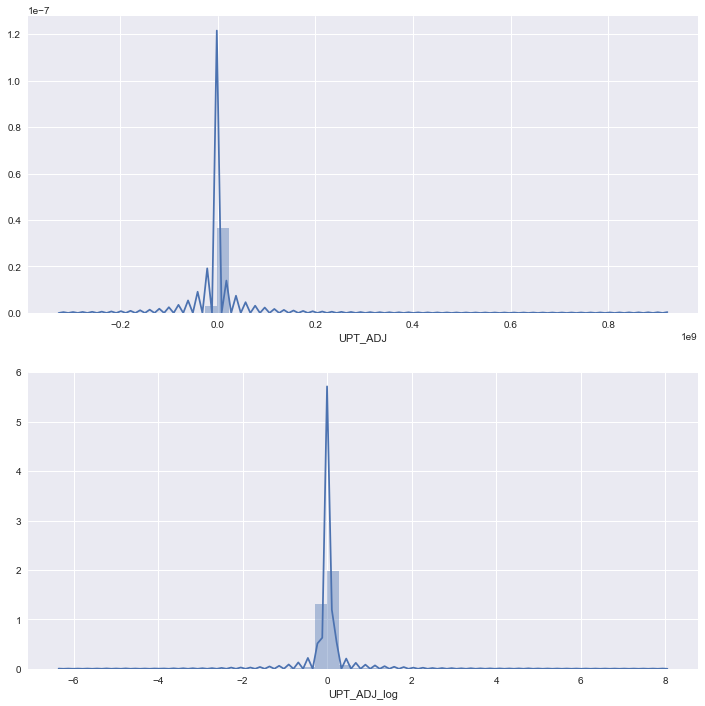

In [32]:
var = 'UPT_ADJ'

# below is generic
f, axes = plt.subplots(2, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(df[var], label='First Diff', ax=axes[0])
sns.distplot(df[var+'_log'], label='First Diff of Log', ax=axes[1])

plt.show()

Excluding 263 records with missing values.


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


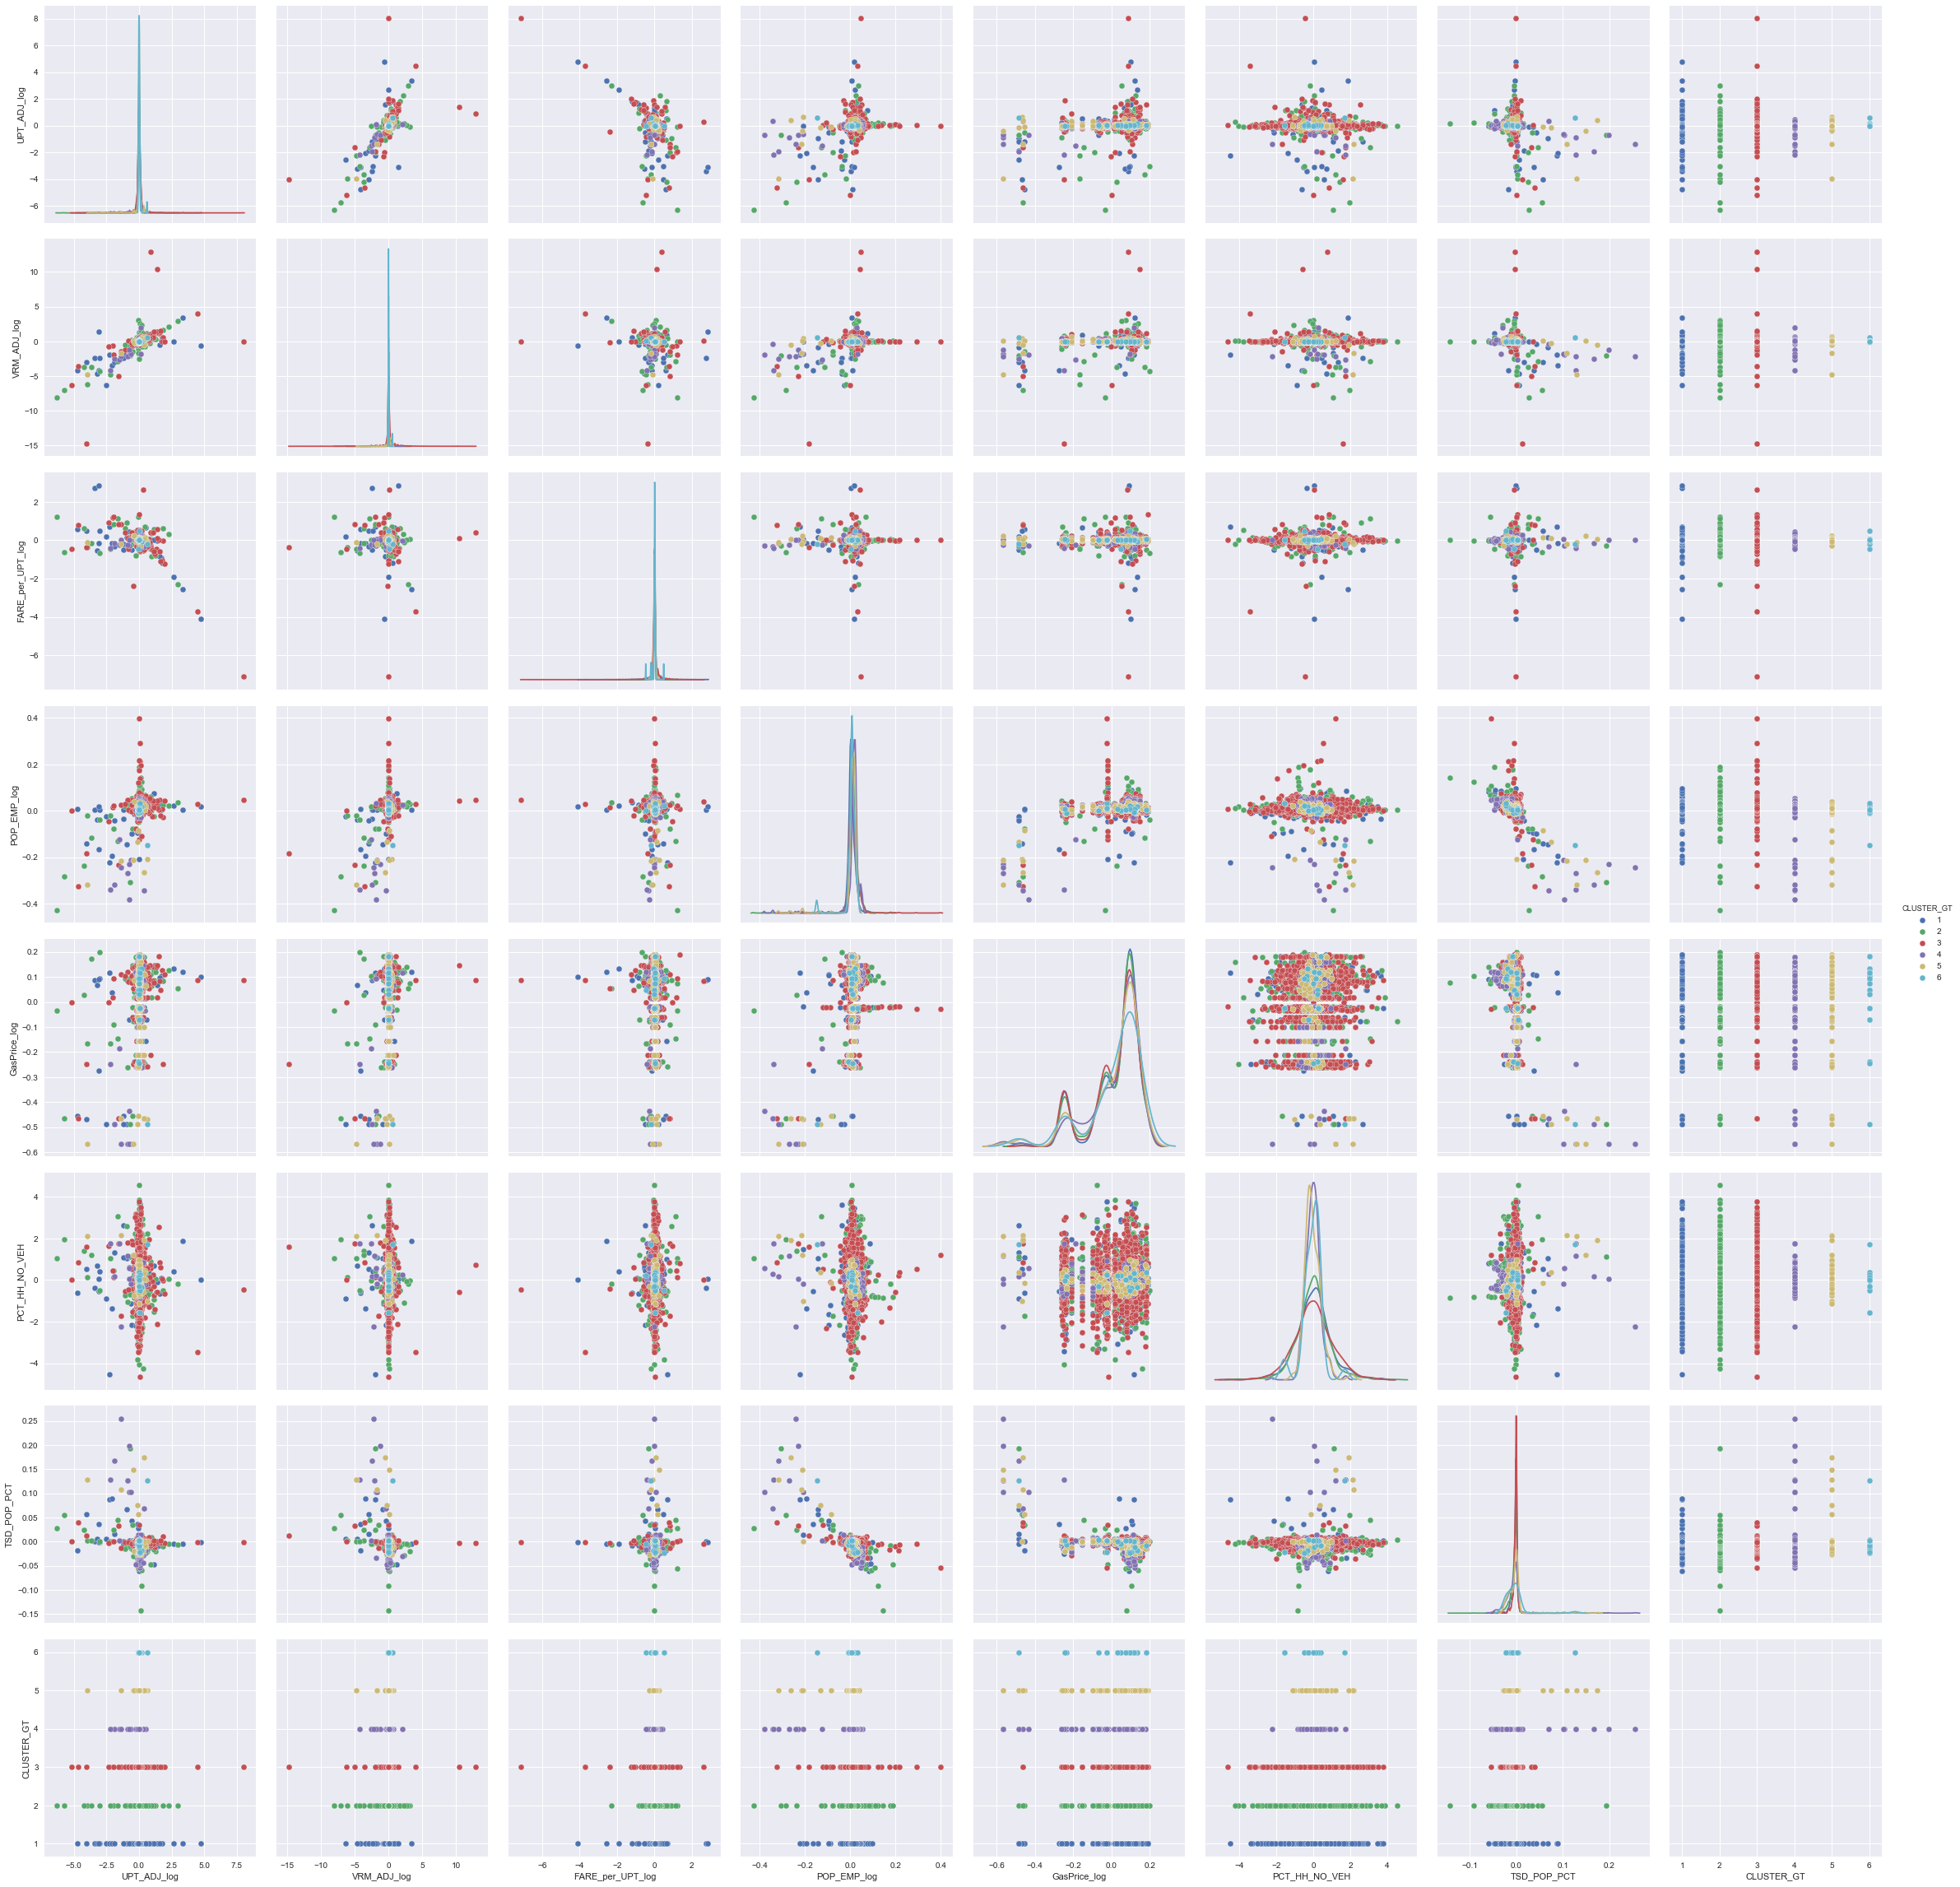

In [33]:
# look at some pair plots

df2 = df[['UPT_ADJ_log', 
         'VRM_ADJ_log', 
         'FARE_per_UPT_log', 
         'POP_EMP_log', 
         'GasPrice_log', 
         'PCT_HH_NO_VEH', 
         'TSD_POP_PCT', 
         'CLUSTER_GT']]

# check for missing data
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()
len_diff = len(df) - len(df2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(df2, hue=('CLUSTER_GT'), diag_kind='kde', dropna=True, size=4)
plt.savefig('pairplot_model.png')


In [34]:
# show the correlation matrix
df2.corr().style.background_gradient(cmap='Reds')

Excluding 263 records with missing values.


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


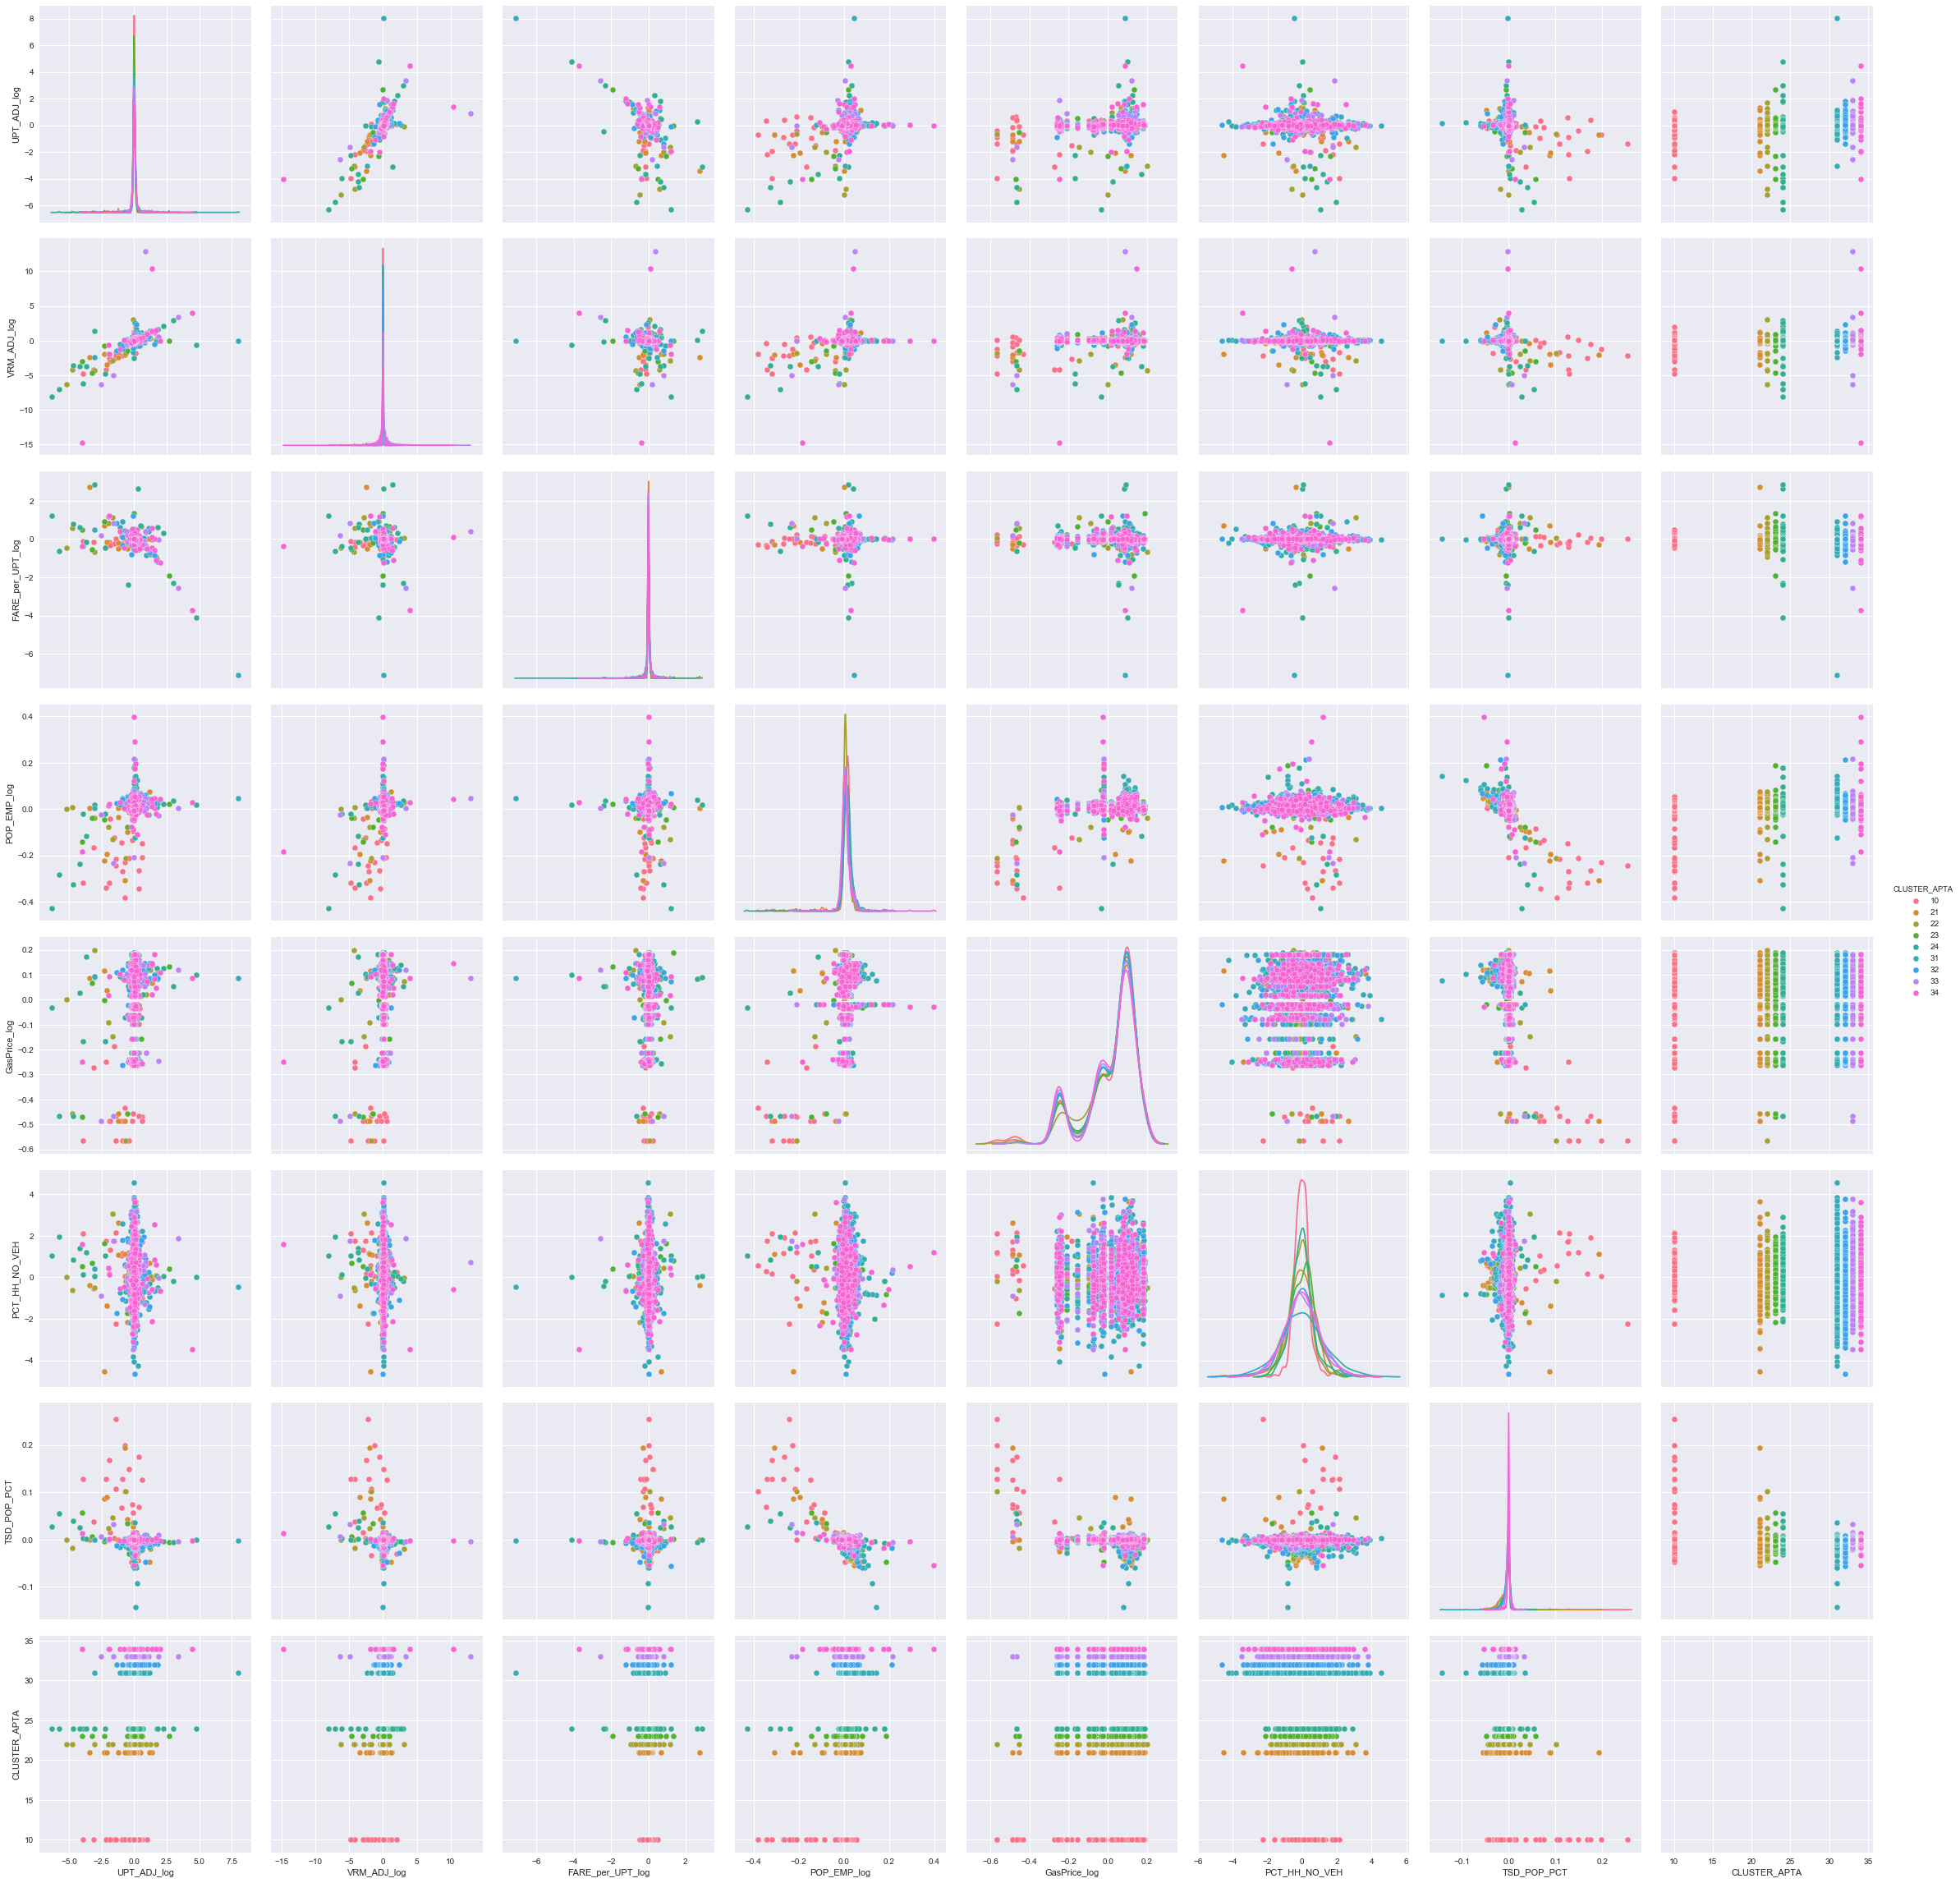

In [35]:
# look at some pair plots

df3 = df[['UPT_ADJ_log', 
         'VRM_ADJ_log', 
         'FARE_per_UPT_log', 
         'POP_EMP_log', 
         'GasPrice_log', 
         'PCT_HH_NO_VEH', 
         'TSD_POP_PCT', 
         'CLUSTER_APTA']]

# check for missing data
df3 = df3.replace([np.inf, -np.inf], np.nan)
df3 = df3.dropna()
len_diff = len(df) - len(df3)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(df3, hue=('CLUSTER_APTA'), diag_kind='kde', dropna=True, size=4)

In [36]:
# show the correlation matrix
df3.corr().style.background_gradient(cmap='Reds')

Excluding 263 records with missing values.


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


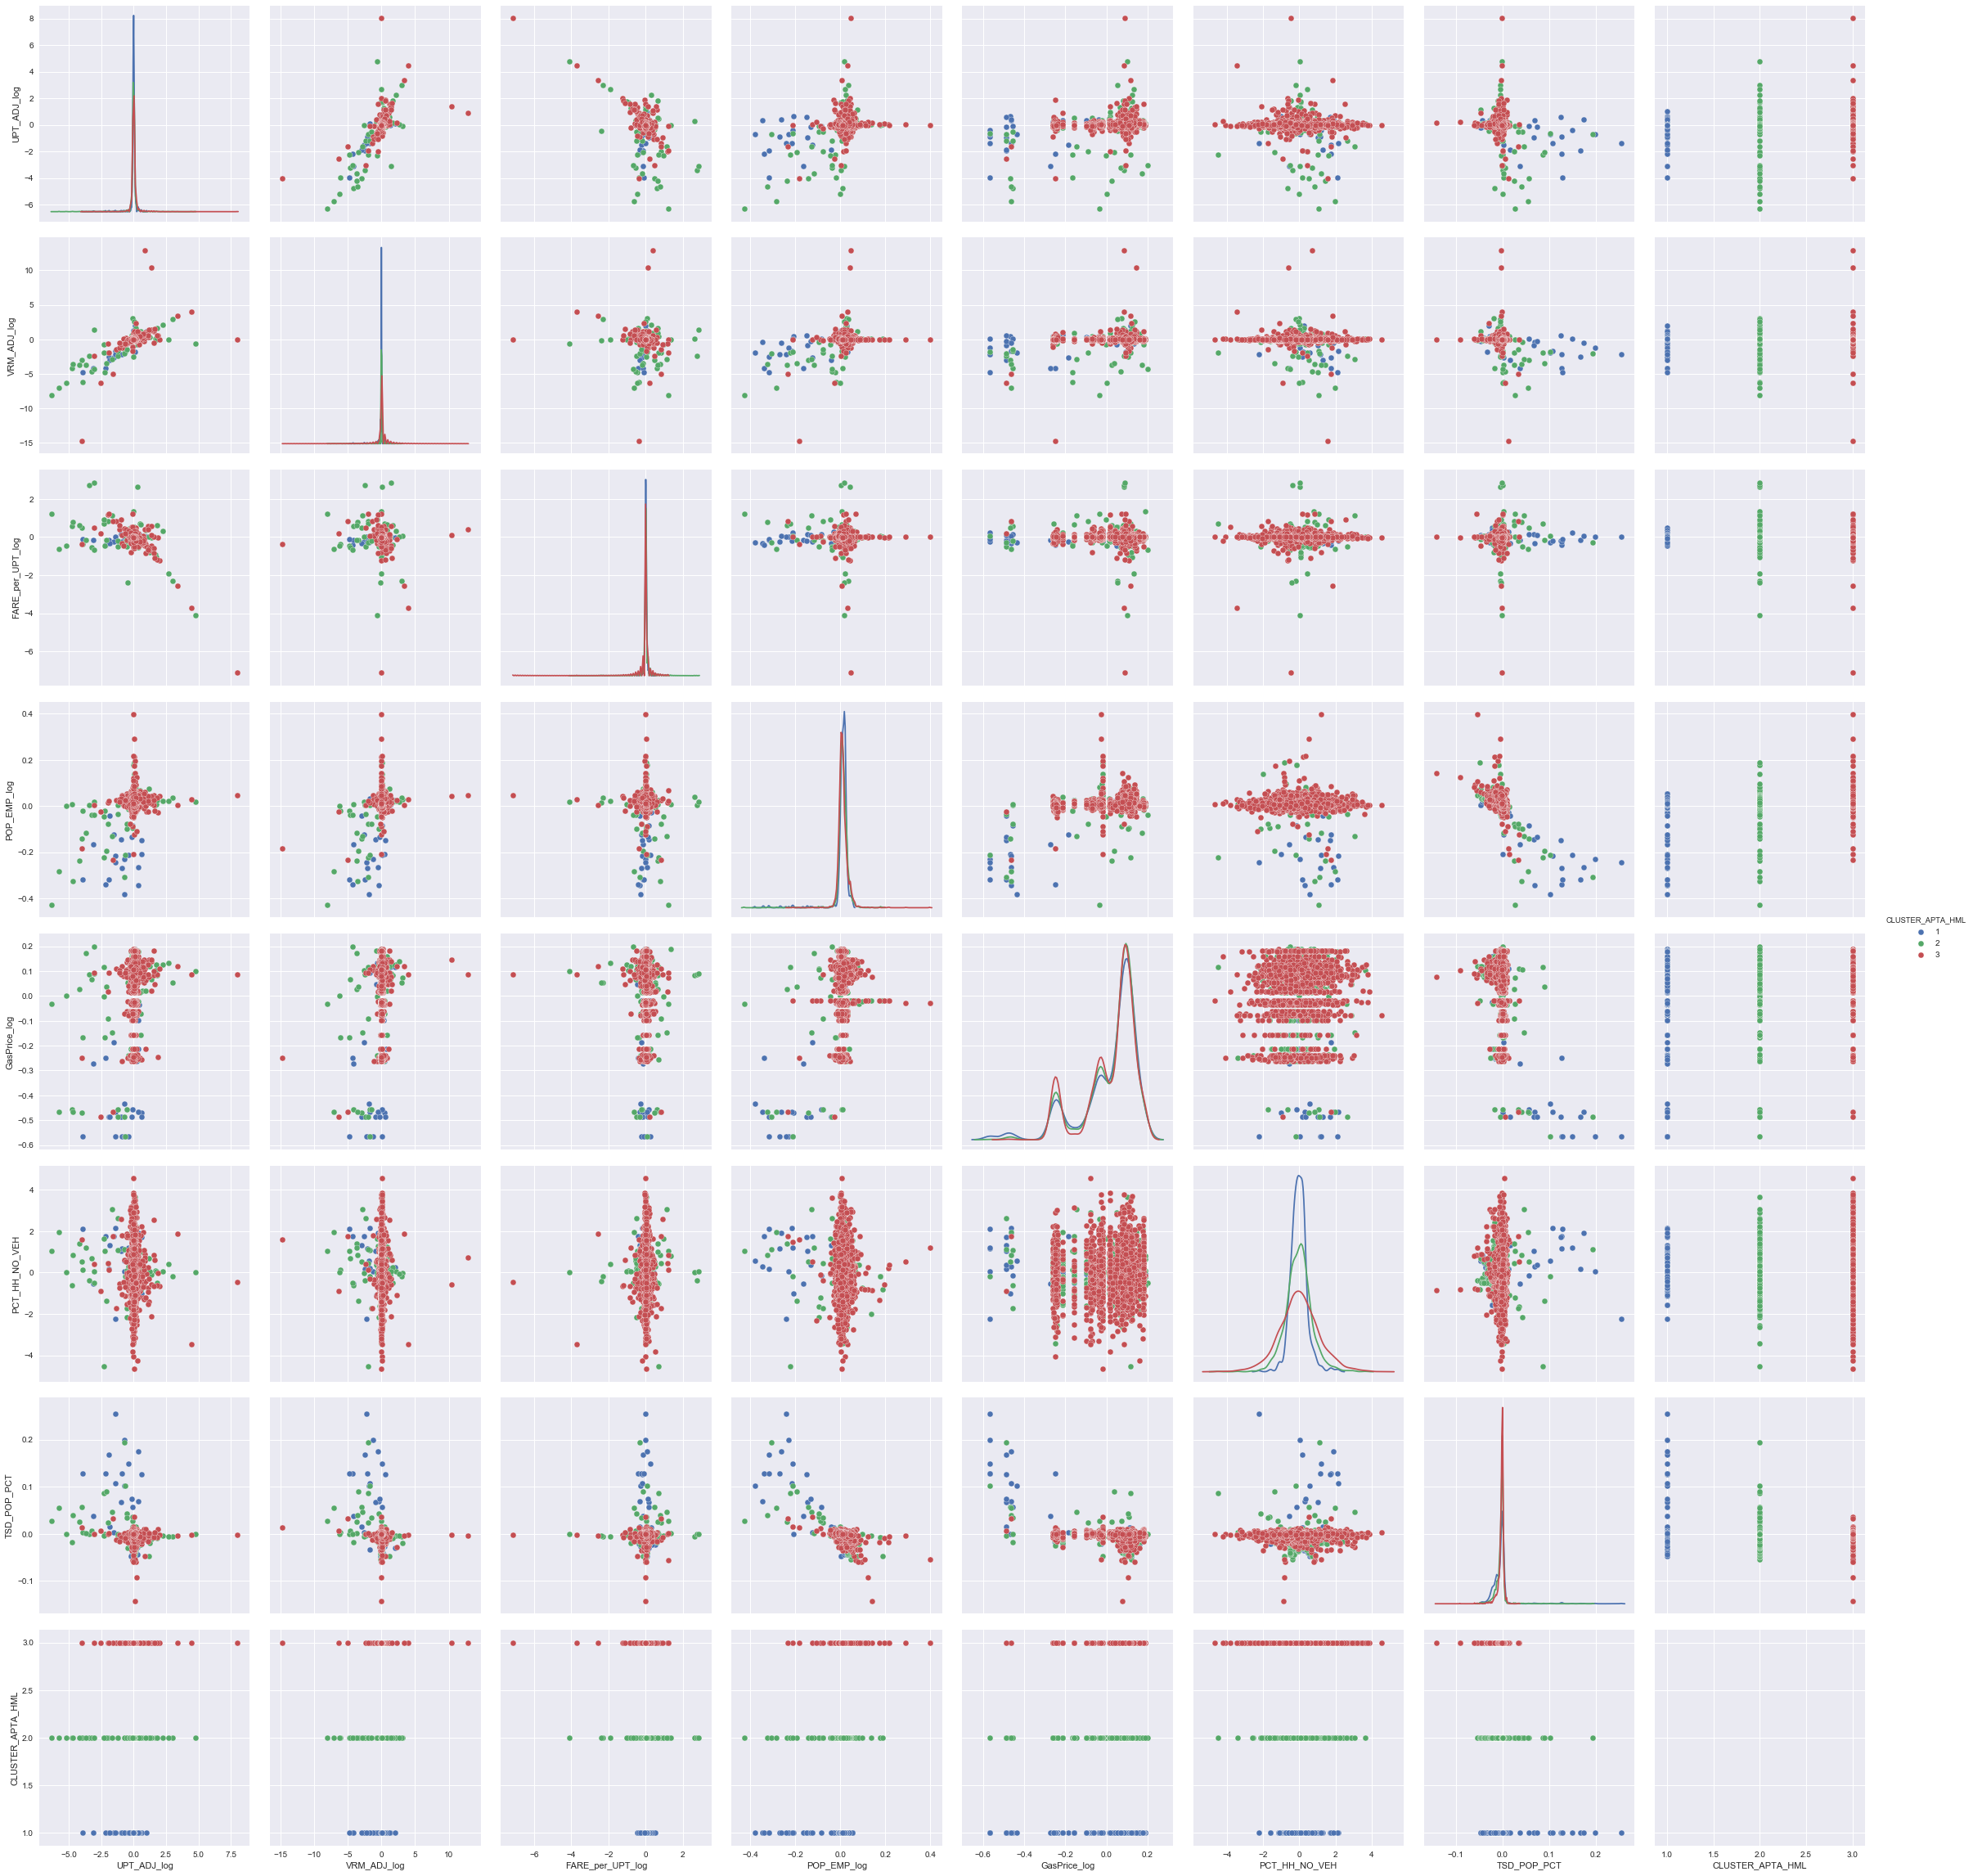

In [37]:
# look at some pair plots

df4 = df[['UPT_ADJ_log', 
         'VRM_ADJ_log', 
         'FARE_per_UPT_log', 
         'POP_EMP_log', 
         'GasPrice_log', 
         'PCT_HH_NO_VEH', 
         'TSD_POP_PCT', 
         'CLUSTER_APTA_HML']]

# check for missing data
df4 = df4.replace([np.inf, -np.inf], np.nan)
df4 = df4.dropna()
len_diff = len(df) - len(df4)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(df4, hue=('CLUSTER_APTA_HML'), diag_kind='kde', dropna=True, size=4)

In [38]:
# show the correlation matrix
df4.corr().style.background_gradient(cmap='Reds')